<center>
   
## [Acoustic Metamaterial Generative Design and Optimisation Pipeline](https://github.com/frantic0/ammgdop)

Author: [Francisco Bernardo](https://fbernardo.com). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

This notebook implements basic data analysis and the required post-processing operations for extracting measurements from the acoustic pressure field obtained from the Helmholtz solver. Metrics include:

* Transmission Loss
* Acoustic Velocity
* Peak Acoustic Pressure (TBC)

To set up the notebook with the required dependencies make sure you have them installed in the system, before you load the notebook. Use your package manager such as conda or pip to install then, for instance:

> $ pip3 install numpy

> $ pip3 install pandas

> $ pip3 install matplotlib


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pd.set_option("display.precision", 2)

To start analysing  on labyrinthine bricks [dataset](https://bigml.com/user/francisco/gallery/dataset/5163ad540c0b5e5b22000383) let's read the data using `parseDatNames`

In [68]:
def parseDatNames(filename):
    res = [] # Initialize
    if filename[-6:] != ".names":
        filename = filename + ".names"
    with open(filename, 'r') as f:
        isHeader = True
        for line in f:
            if 'Variables in columns' in line:
                isHeader = False
                continue
            if isHeader == True:
                continue

            # strParse1: get rid of 1: boundary mean, and split over "over"
            strParse1 = line.strip().split(':')[-1].strip().split('over')
            if len(strParse1) == 1:
                res.append(strParse1[0])
            else:
                if len(strParse1[0]) > 0:
                    itemName = strParse1[0]
                else:
                    strParse1[0] = itemName
                res.append(strParse1[0].strip() + '.' + strParse1[1].strip())
    return res

Let's take a look at the column names exported by Elmer for Brick 15:

In [69]:
filename = './data/brick-15/SPLmean.dat'

# Boundary Conditions
inletBC = 1
outletBC = 3

rho0 = 1.205
c0 = 343
flowDir = np.array([1, 0, 0]);

# Parse input names:
column_names = parseDatNames(filename)

print(*column_names, sep ='\n')

pressure wave 1.bc 1
pressure wave 1.bc 3
pressure wave 2.bc 1
pressure wave 2.bc 3
pressure wave 1 grad 1.bc 1
pressure wave 1 grad 1.bc 3
pressure wave 2 grad 1.bc 1
pressure wave 2 grad 1.bc 3
pressure wave 1 grad 2.bc 1
pressure wave 1 grad 2.bc 3
pressure wave 2 grad 2.bc 1
pressure wave 2 grad 2.bc 3
pressure wave 1 grad 3.bc 1
pressure wave 1 grad 3.bc 3
pressure wave 2 grad 3.bc 1
pressure wave 2 grad 3.bc 3
frequency


Let’s have a look at data dimensionality, feature names, and feature types.

In [70]:
with open(filename, 'r') as f:
    res = np.array([np.fromstring(line.strip(), dtype=float, sep=' ') for line in f])

print("Shape of the data: {} \n".format(res.shape))          
  

print(res)


Shape of the data: (3, 17) 

[[ 9.99996690e-01  1.76879102e-01 -3.58492989e-44 -5.10295667e-01
  -3.83938528e-01 -7.46498713e+01 -9.12031019e-02 -1.46054697e+02
   6.47656558e-03  5.62639495e-01  4.15000539e-01  1.39955167e+00
   4.14708727e+03  9.68715905e+01 -1.66532702e+02 -3.37477927e+02
   4.00000000e+04]
 [ 9.99996690e-01 -1.40323266e+00  1.98647431e-42 -1.05654505e+00
  -1.23002487e+00 -6.02109086e+02 -5.20674467e-01  7.69857276e+02
  -2.35536803e+00  2.54414021e-01 -4.83584558e+00 -3.78356692e-01
  -2.66993452e+03 -8.08441723e+02 -1.47047750e+04  1.25732054e+03
   4.05000000e+04]
 [ 9.99996690e-01  8.19907481e-02 -9.24674080e-46  1.43998552e-01
   8.27310984e-02  4.45522274e+02  1.36980477e+00 -1.84192777e+02
  -3.86833498e+00  4.14476253e+00 -5.34629312e-01  5.07198960e+00
  -5.99931059e+03  8.31491620e+02 -2.27324882e+03 -1.04386145e+02
   4.10000000e+04]]


<details>
<summary>About printing DataFrames in Jupyter notebooks</summary>
<p>
In Jupyter notebooks, Pandas DataFrames are printed as these pretty tables seen above while `print(df.head())` is less nicely formatted.
By default, Pandas displays 20 columns and 60 rows, so, if your DataFrame is bigger, use the `set_option` function as shown in the example below:

```python
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
```
</p>
</details>

Recall that each row corresponds to one client, an **instance**, and columns are **features** of this instance.

Let's now get the frequency and pressure values and assign to variables

In [79]:
freqVec = res[:, column_names.index('frequency')]
omegaVec = 2 * np.pi * freqVec

## Get pressure at inlet and outlet

pIn = res[:, column_names.index('pressure wave 1.bc ' + str(inletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(inletBC))]

pOut = res[:, column_names.index('pressure wave 1.bc ' + str(outletBC))] \
     + 1j * res[:, column_names.index('pressure wave 2.bc ' + str(outletBC))]

print(pIn)
print(pOut)

[0.99999669-3.58492989e-44j 0.99999669+1.98647431e-42j
 0.99999669-9.24674080e-46j]
[ 0.1768791 -0.51029567j -1.40323266-1.05654505j  0.08199075+0.14399855j]



To calculate velocity at inlet, we use  

**uIn = 1j / rho0 / omegaVec * dp/dn**

To decompose the p to p+ and p-, we notice that

**p+ + p- = p**

**p+ - p- = uIn * rho0 * c0**

so, 

**p+ = (p + uIn * rho0 * c0) / 2**


In [76]:
#  Check if it is 3D
dim = 3
if "pressure wave 1 grad 3.bc 1" not in column_names:
    dim = 2
    flowDir = flowDir[:-1]

pGradIn, pGradOut = np.zeros((freqVec.size, dim), dtype=np.complex_), np.zeros((freqVec.size, dim), dtype=np.complex_)

# Get pGradIn and pGradOut
fmt = 'pressure wave {0:d} grad {1:d}.bc {2:s}'
for ind in range(dim):
    # Inlet
    strReal = fmt.format(1, ind+1, str(inletBC))
    strImag = fmt.format(2, ind+1, str(inletBC))
    pGradIn[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]
    # outlet
    strReal = fmt.format(1, ind+1, str(outletBC))
    strImag = fmt.format(2, ind+1, str(outletBC))
    pGradOut[:, ind] = res[:, column_names.index(strReal)] + 1j * res[:, column_names.index(strImag)]
    
# Decomposition at inlet
dpdnIn = pGradIn.dot(flowDir)
uIn = 1j/rho0/omegaVec*dpdnIn
pInPlus = (pIn + uIn*rho0*c0)/2
pInMinus = pIn - pInPlus

# Decomposition at outlet
dpdnOut = pGradOut.dot(flowDir)
uOut = 1j/rho0/omegaVec*dpdnOut


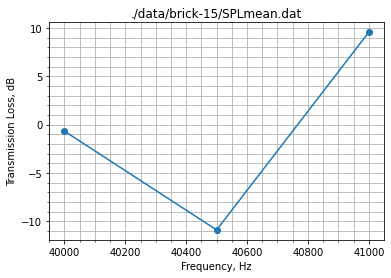

In [81]:
# Transmission Loss
TL = 20*np.log10(np.abs(pInPlus)/np.abs(pOut))

# Plot
plt.close("all")
fig, ax = plt.subplots()
ax.minorticks_on()
ax.grid(which='both')
ln = plt.plot(freqVec, TL, '-o', label='Simulation')
plt.xlabel('Frequency, Hz')
plt.ylabel('Transmission Loss, dB')
plt.title(filename)
plt.show()

